In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras 
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import Dropout, Activation

from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K

import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

#Dataset

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm images/*.mat

Output streaming akan dipotong hingga 5000 baris terakhir.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/po

#Generators

In [3]:
def image_generator(files, batch_size=32, sz = (256,256)):
  while True:
    #extract random batch
    batch = np.random.choice(files, size = batch_size)

    #container for input and output batches
    batch_x = []
    batch_y = []
    for f in batch:
      #extract mask
      mask=Image.open(f'annotations/trimaps/{f[:-4]}.png')
      mask=np.array(mask.resize(sz))

      #preprocess mask
      mask[mask >=2 ] = 0
      mask[mask !=0 ] = 1

      batch_y.append(mask)

      #preprocess raw images
      raw=Image.open(f'images/{f}')
      raw=raw.resize(sz)
      raw=np.array(raw)

      #check image channel if RGB or GRAY
      if len(raw.shape) == 2:
        raw = np.stack((raw,)*3,axis=-1)
      else:
        raw=raw[:,:,0:3]
      batch_x.append(raw)
    #preprocess image batches
    batch_x=np.array(batch_x)/255.
    batch_y=np.array(batch_y)
    batch_y=np.expand_dims(batch_y,3)

    yield(batch_x,batch_y)

In [4]:
batch_size=32
all_files = os.listdir('images')
shuffle(all_files)

#split to training and testing
split = int(0.95*len(all_files))

train_files=all_files[0:split]
test_files=all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator = image_generator(test_files, batch_size = batch_size)

In [5]:
x, y = next(train_generator)

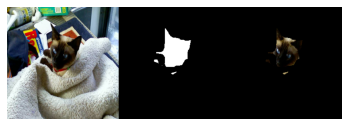

In [6]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow(np.concatenate([img,msk,img*msk],axis=1))

#IoU Metrics

In [7]:
def mean_iou(y_true,y_pred):
  yt0=y_true[:,:,:,0]
  yp0=K.cast(y_pred[:,:,:,0]>0.5,'float32')
  inter=tf.math.count_nonzero(tf.logical_and(tf.equal(yt0,1), tf.equal(yp0,1)))
  union=tf.math.count_nonzero(tf.add(yt0, yp0))
  iou=tf.where(tf.equal(union,0),1.,tf.cast(inter/union, 'float32'))
  return iou 

#Model

In [8]:
def unet(sz=(256,256,3)):
  x=Input(sz)
  inputs=x

  #Encoder/Downsampling
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 

  #bottleneck/code/Latent Space Representation
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 

  #Decoder/Upsampling
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
  
  #classification
  x=Conv2D(f,3,activation='relu',padding='same')(x)
  x=Conv2D(f,3,activation='relu',padding='same')(x)
  outputs=Conv2D(1,1,activation='sigmoid')(x)
  
  #model
  model=Model(inputs=[inputs],outputs=[outputs])
  model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=[mean_iou])

  return model


In [9]:
  model=unet()

#Callbacks

In [10]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

#Training

Epoch 1/5
1/1 [==============================] - 0s 108ms/step


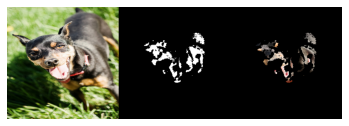

219/219 [==============================] - 2661s 12s/step - loss: 0.5164 - mean_iou: 0.1046 - val_loss: 0.5116 - val_mean_iou: 0.2210
Epoch 2/5
1/1 [==============================] - 0s 150ms/step


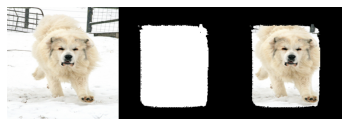

219/219 [==============================] - 2663s 12s/step - loss: 0.4606 - mean_iou: 0.4275 - val_loss: 0.5384 - val_mean_iou: 0.5013
Epoch 3/5
1/1 [==============================] - 0s 117ms/step


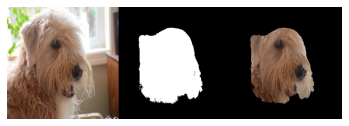

219/219 [==============================] - 2683s 12s/step - loss: 0.4372 - mean_iou: 0.4469 - val_loss: 0.3981 - val_mean_iou: 0.4952
Epoch 4/5
1/1 [==============================] - 0s 212ms/step


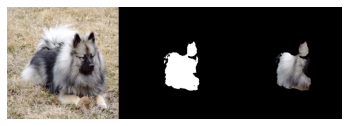

219/219 [==============================] - 2586s 12s/step - loss: 0.4090 - mean_iou: 0.4864 - val_loss: 0.4389 - val_mean_iou: 0.3762
Epoch 5/5
1/1 [==============================] - 0s 109ms/step


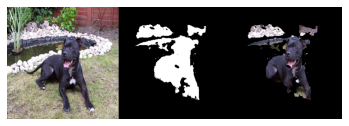

219/219 [==============================] - 2565s 12s/step - loss: 0.3784 - mean_iou: 0.5282 - val_loss: 0.3984 - val_mean_iou: 0.5825


In [14]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator, epochs=5, steps_per_epoch=train_steps,validation_data=test_generator, validation_steps=test_steps,callbacks=build_callbacks())

#Testing

In [15]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2023-03-23 19:45:33--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.32.87.69, 13.32.87.32, 13.32.87.65, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.32.87.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.02s   

2023-03-23 19:45:33 (2.59 MB/s) - ‘test.jpg’ saved [63219/63219]



1/1 [==============================] - 0s 116ms/step


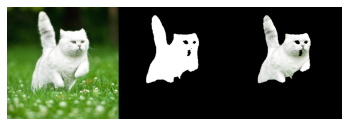

In [17]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()